# Jigsaw Aerial Photography

Cut out garden shapes from Aerial Photography layer

- load garden shapes derived in ppp06
- collocate Aerial photography and topograhpic layer (align to BNG)
- cut out garden images and save each to individual file
    - maybe need to do some rotation of images?

### raster vs vector data useful intro
https://carpentries-incubator.github.io/geospatial-python/aio/index.html

libraries for raster data
- rasterio
- rioxarray

libraries for vector data
- geopandas
- geocube

### overview of essential geospatial python libraries
https://medium.com/@chrieke/essential-geospatial-python-libraries-5d82fcc38731

### crop raster with vector

- earthpy
- rasterio
- cartopy

https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/crop-raster-data-with-shapefile-in-python/

https://www.earthdatascience.org/workshops/gis-open-source-python/crop-raster-data-in-python/

## Libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_column', 100) #set max number of cols to display before ...

In [2]:
import glob

In [3]:
import earthpy as et 
import earthpy.spatial as es 
import earthpy.plot as ep #to plot np array of RGB pixel numbers
import cartopy as cp

In [4]:
import mplleaflet
import folium
import fiona
import pyproj
import contextily
import shapely as shp

import rasterio
from rasterio._base import gdal_version
#https://rasterio.readthedocs.io/en/latest/
import rasterio.warp
import rasterio.features
from rasterio import plot #essential to plot images in BNG, in correct position, and full RGB 

In [5]:
from rasterio.mask import mask

In [6]:
#check correct environment is being used: parkprov
print(sys.executable)

/Users/tamsinforbes/anaconda3/envs/parkprov/bin/python


## Load lookup_rd_gdn

lookup_rd_gdn.csv is a lookup table derived in ppp06 in which each roadside garden polygon toid is linked with a residential dwelling building shape toid by the INSPIREID of the land registry land parcel that their representative points lie within. There are duplicates in this, multiple buildings and gardens associated with the same land parcel. Put this down to flats, new developments of housing estates, splitting of a single dwelling into multiple residences. 

In [7]:
#drop index column and specify to read toids as strings
#they have been saved with the leading zeroes preserved by pandas will drop leading zeroes by default
#and read in as int
lookup_rd_gdn = pd.read_csv("../data/lookup_rd_gdn.csv",
                           dtype={'INSPIREID': object, 'rd_poly_toid': object, 'gdn_poly_toid': object}
                           ).drop(['Unnamed: 0'], axis = 1)
#forgot to not write the index column

In [8]:
lookup_rd_gdn.columns

Index(['INSPIREID', 'rd_poly_toid', 'gdn_poly_toid'], dtype='object')

In [9]:
lookup_rd_gdn.dtypes

INSPIREID        object
rd_poly_toid     object
gdn_poly_toid    object
dtype: object

In [10]:
lookup_rd_gdn

,INSPIREID,rd_poly_toid,gdn_poly_toid
0,35014222,0001000003513013,5000005125902450
1,35014259,0001000003513012,1000001778713698
2,35014286,0001000003513011,1000001778713632
3,35014325,0001000003513010,1000001778714168
4,35014359,0001000003513009,1000001778713624
...,...,...,...
1580,34972889,0001000003512863,1000001778714198
1581,34979821,0001000003512944,1000001778713968
1582,34972646,0001000003512862,1000001778714195
1583,34972781,0001000003512861,1000001778713497


## Load Topographic Area TQ1980

In [11]:
path = "../data/eTopoArea_1980/eTopoArea_1980.gpkg"
for layername in fiona.listlayers(path):
    with fiona.open(path, layer=layername) as src:
        print(layername, len(src))
        
ta = gpd.read_file(path)

eTopoArea_1980 7200


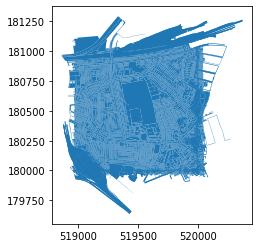

In [12]:
ta.plot()

In [13]:
ta.dtypes

id                          int64
OBJECTID                    int64
TOID                       object
FeatureCode                 int64
Version                     int64
VersionDate                object
Theme                      object
ThemeCount                  int64
CalculatedAreaValue       float64
ChangeDate                 object
ReasonForChange            object
ChangeHistoryCount          int64
DescriptiveGroup           object
DescriptiveGroupCount       int64
DescriptiveTerm            object
DescriptiveTermCount      float64
Make                       object
PhysicalLevel               int64
PhysicalPresence           object
broken                     object
SHAPE_Length              float64
SHAPE_Area                float64
geometry                 geometry
dtype: object

In [14]:
ta.head()

,id,OBJECTID,TOID,FeatureCode,Version,VersionDate,Theme,ThemeCount,CalculatedAreaValue,ChangeDate,ReasonForChange,ChangeHistoryCount,DescriptiveGroup,DescriptiveGroupCount,DescriptiveTerm,DescriptiveTermCount,Make,PhysicalLevel,PhysicalPresence,broken,SHAPE_Length,SHAPE_Area,geometry
0,643242,643242,5000005125902538,10123,1,2014-05-29T00:00:00,Roads Tracks And Paths,1,44.669666,2014-04-29T00:00:00,New,1,Path,1,None,NaN,Manmade,50,None,false,32.838010,44.669666,"POLYGON ((519539.020 179987.631, 519545.071 17..."
1,643243,643243,1000001793846362,10056,2,2008-03-18T00:00:00,Land,1,66.485440,2006-12-06T00:00:00,New,1,General Surface,1,None,NaN,Natural,50,None,false,47.312817,66.485450,"POLYGON ((519561.040 179973.500, 519560.150 17..."
2,643244,643244,1000001793846365,10056,2,2008-03-18T00:00:00,Land,1,32.208200,2006-12-06T00:00:00,New,1,General Surface,1,None,NaN,Natural,50,None,false,34.586030,32.208200,"POLYGON ((519506.710 179985.100, 519507.260 17..."
3,643251,643251,1000001778929145,10056,4,2008-03-18T00:00:00,Land,1,14.644856,2006-12-06T00:00:00,New,1,General Surface,1,None,NaN,Natural,50,None,false,51.548592,14.644850,"POLYGON ((519513.020 180000.000, 519513.250 18..."
4,643252,643252,1000001778929144,10056,6,2014-05-29T00:00:00,Land,1,1152.839530,2014-04-29T00:00:00,Modified,3,General Surface,1,None,NaN,Manmade,50,None,false,299.453631,1152.839530,"POLYGON ((519512.340 180007.310, 519514.020 18..."


## Load Aerial Photography TQ1980

See ppp03 for full details

In [15]:
ealing_tif_paths = glob.glob(
    '../data/APEaling_111706_20200601/25cm_Aerial_Photo/111706-1_RGB_1_Shape/*.tif', recursive=True)
ealing_tif_paths[10]

'../data/APEaling_111706_20200601/25cm_Aerial_Photo/111706-1_RGB_1_Shape/TQ1980.tif'

In [16]:
src = rasterio.open(ealing_tif_paths[10])
print("path: ", src.name, "\nmode: ", src.mode, "\nis closed?: ", src.closed
      , "\nband count: ", src.count, "\nshape: ", src.shape)

path:  ../data/APEaling_111706_20200601/25cm_Aerial_Photo/111706-1_RGB_1_Shape/TQ1980.tif 
mode:  r 
is closed?:  False 
band count:  3 
shape:  (4000, 4000)


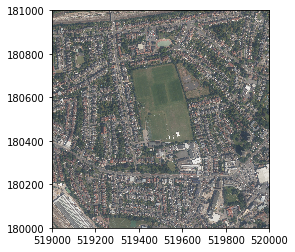

In [17]:
#make sure 'from rasterio import plot' is run ffs
plot.show(src)

## Filter ta for my list of gdn_poly_toid

In [18]:
#remove duplicates and create list of garden toids
gdn_toid_list = lookup_rd_gdn['gdn_poly_toid'].drop_duplicates().tolist()
#filter ta for these toids
gdn = ta[ta['TOID'].isin(gdn_toid_list)]

In [19]:
print(gdn.shape)
gdn.head()

(1447, 23)


,id,OBJECTID,TOID,FeatureCode,Version,VersionDate,Theme,ThemeCount,CalculatedAreaValue,ChangeDate,ReasonForChange,ChangeHistoryCount,DescriptiveGroup,DescriptiveGroupCount,DescriptiveTerm,DescriptiveTermCount,Make,PhysicalLevel,PhysicalPresence,broken,SHAPE_Length,SHAPE_Area,geometry
13,643654,643654,1000001778783950,10053,7,2015-01-15T00:00:00,Land,1,696.324061,2015-01-11T00:00:00,Modified,2,General Surface,1,Multi Surface,1.0,Multiple,50,None,false,448.361385,696.324061,"POLYGON ((519657.544 180045.614, 519659.195 18..."
74,644905,644905,1000001778708314,10053,6,2008-03-18T00:00:00,Land,1,18.536248,2007-10-11T00:00:00,Attributes,3,General Surface,1,Multi Surface,1.0,Multiple,50,None,false,25.102976,18.536250,"POLYGON ((519787.350 180008.450, 519790.150 18..."
80,644935,644935,1000001778708000,10053,8,2019-11-04T00:00:00,Land,1,101.016240,2019-11-01T00:00:00,Modified,5,General Surface,1,Multi Surface,1.0,Multiple,50,None,false,75.725109,100.950737,"POLYGON ((519573.550 179999.850, 519577.200 17..."
160,646641,646641,1000001778708002,10053,6,2008-03-18T00:00:00,Land,1,15.126256,2001-05-31T00:00:00,Reclassified,3,General Surface,1,Multi Surface,1.0,Multiple,50,None,false,16.324930,15.126250,"POLYGON ((519590.900 180004.300, 519593.300 18..."
199,647747,647747,1000001778708315,10053,5,2008-03-18T00:00:00,Land,1,13.905024,2000-06-02T00:00:00,New,2,General Surface,1,Multi Surface,1.0,Multiple,50,None,false,15.427639,13.905000,"POLYGON ((519790.150 180001.300, 519794.750 18..."


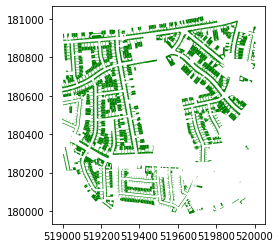

In [20]:
gdn.plot(color = 'green')

## Plot AP and TA

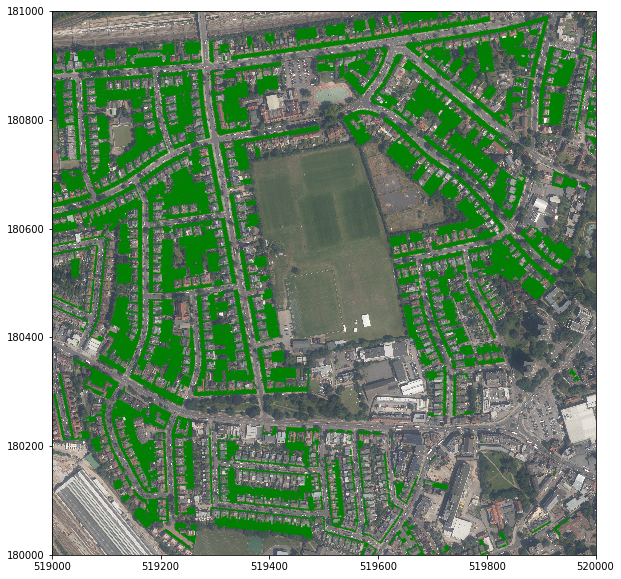

In [21]:
base = gdn.plot(figsize=(10,10),color = 'green')
plot.show(src, ax = base) #uses rasterio plot module

## Use rasterio.mask.mask to crop & mask raster with polygon

https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html
https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html

Method using cv2 and saving as png
https://stackoverflow.com/questions/15341538/numpy-opencv-2-how-do-i-crop-non-rectangular-region

In [22]:
#create gdf of a single garden vector polygon
gdn1 = gdn.query('TOID == "1000001778783950"').drop(['id', 'OBJECTID'], axis=1).drop_duplicates()

In [23]:
gdn1.geometry

13    POLYGON ((519657.544 180045.614, 519659.195 18...
Name: geometry, dtype: geometry

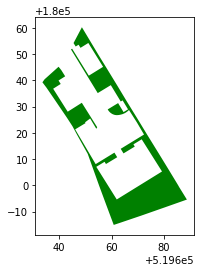

In [24]:
gdn1.plot(color = 'green')

In [25]:
im1, im1_trans = mask(dataset = src #open raster tif file
                    , shapes = gdn1.geometry #shapley polygon geometry column of gdf
                    , crop = True #crop to North and East extent of image
                    , all_touched = True #include a pixel if it touches any of the shapes
                    , nodata = 255 #set nodata value for all RGB layers, 255 = white, 0 = black
                    , filled = True
                    
                   ) 

In [26]:
im1_trans #only returns the transform meta data (ep.crop_image returns all metadata)

Affine(0.25, 0.0, 519633.5,
       0.0, -0.25, 180060.25)

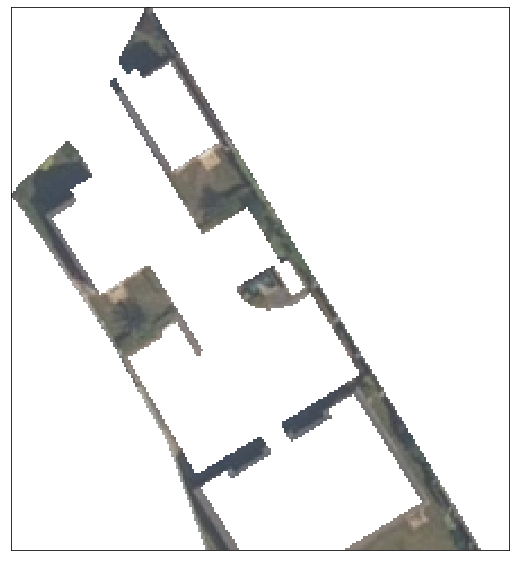

In [27]:
ep.plot_rgb(im1)
#this garden is not actually entirely within the TQ1980 grid, hence the bottom edge is missing!
#would be useful to know where the roadside is?

## Save image
- save ti tif or png?
- include meta data from original image
- include BNG grid datum info

In [28]:
#set crop/masked image meta data to parent meta data
im1_meta = src.meta

In [29]:
#update meta data
im1_meta.update({"driver": "GTiff",
                 "height": im1.shape[1],
                 "width": im1.shape[2],
                 "transform": im1_trans})

im1_meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 221,
 'height': 241,
 'count': 3,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(0.25, 0.0, 519633.5,
        0.0, -0.25, 180060.25)}

In [147]:
#write to tif

with rasterio.open("../garden_shape/im1_test.tif", mode = "w", **im1_meta) as dest:
    dest.write(im1)

## check can read in saved shape

In [148]:
im = rasterio.open("../garden_shape/im1_test.tif")

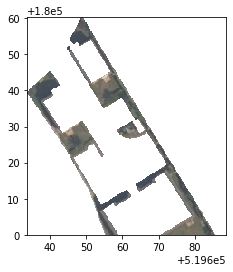

In [150]:
plot.show(im)
#yay it works!

In [189]:
gdn.head()

,id,OBJECTID,TOID,FeatureCode,Version,VersionDate,Theme,ThemeCount,CalculatedAreaValue,ChangeDate,ReasonForChange,ChangeHistoryCount,DescriptiveGroup,DescriptiveGroupCount,DescriptiveTerm,DescriptiveTermCount,Make,PhysicalLevel,PhysicalPresence,broken,SHAPE_Length,SHAPE_Area,geometry
13,643654,643654,1000001778783950,10053,7,2015-01-15T00:00:00,Land,1,696.324061,2015-01-11T00:00:00,Modified,2,General Surface,1,Multi Surface,1.0,Multiple,50,None,false,448.361385,696.324061,"POLYGON ((519657.544 180045.614, 519659.195 18..."
74,644905,644905,1000001778708314,10053,6,2008-03-18T00:00:00,Land,1,18.536248,2007-10-11T00:00:00,Attributes,3,General Surface,1,Multi Surface,1.0,Multiple,50,None,false,25.102976,18.536250,"POLYGON ((519787.350 180008.450, 519790.150 18..."
80,644935,644935,1000001778708000,10053,8,2019-11-04T00:00:00,Land,1,101.016240,2019-11-01T00:00:00,Modified,5,General Surface,1,Multi Surface,1.0,Multiple,50,None,false,75.725109,100.950737,"POLYGON ((519573.550 179999.850, 519577.200 17..."
160,646641,646641,1000001778708002,10053,6,2008-03-18T00:00:00,Land,1,15.126256,2001-05-31T00:00:00,Reclassified,3,General Surface,1,Multi Surface,1.0,Multiple,50,None,false,16.324930,15.126250,"POLYGON ((519590.900 180004.300, 519593.300 18..."
199,647747,647747,1000001778708315,10053,5,2008-03-18T00:00:00,Land,1,13.905024,2000-06-02T00:00:00,New,2,General Surface,1,Multi Surface,1.0,Multiple,50,None,false,15.427639,13.905000,"POLYGON ((519790.150 180001.300, 519794.750 18..."


In [238]:
src.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 4000,
 'height': 4000,
 'count': 3,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(0.25, 0.0, 519000.0,
        0.0, -0.25, 181000.0)}

## Function to apply to all gardens

Write function to deal with one 1km AP grid and the gardens that are in it. Imagine that to use it over all the grids or specific area will have batched AP areas and gardens they contain into a pair of objects with the same reference. So AP grid TQ1980 and gardens for TQ1980. These should sit in two folders and the jigsaw function would be forlooped over the pairs of data from each folder, or something like that.

SO to scale up there should be some 

- deduplicate garden polygons
- batch into all polygons per 1km grid
- open relevant 1km grid AP file
- for each AP 1km grid cut out all polygons that are entirely within it
- save with grid ref in name, eg TQ1980
- how to collect edge polygons the overlap grids?


Function jigsaw to cut up a single raster image into mulitple raster images from the topographic area garden polygons shapes. The raster image is cropped to the extent of the polygon and the non-garden areas of it masked. Using raster.mask.mask expects a geodataframe, so cut out each individual garden shape must first make a one line geodataframe that contains only that polygon data.


In [247]:
#already read in AP grid and deduplicated polygons
#collect AP grid name for file, this will be part of for loop when scaled up
grid = ealing_tif_paths[10][-10:-4]


In [253]:
def jigsaw(raster, gdf):
    
    #set meta data
    im_meta = raster.meta
    
    for i in np.arange(gdf.shape[0]):
        
        g = gdf.copy(deep=True).iloc[i:i+1] #create single row gdf from gdf of all polygons
        
        #use rasterio.mask.mask from rasterio.mask import mask must be run
        #im: raster np array, im_transform: transform 
        im, im_transform = mask(dataset = raster
                                , shapes = g.geometry #assumes geometry column is named geometry
                                , crop = True #crop to North and East extent of image
                                , all_touched = True #include a pixel if it touches any of the shapes
                                , nodata = 255 #set nodata value for all RGB layers, 255 = white, 0 = black
                                , filled = True 
                               )
        #update meta data
        im_meta.update({"driver": "GTiff"
                        , "height": im.shape[1]
                        ,"width": im.shape[2]
                        ,"transform": im_transform})
        
        #create filename
        filename = "../jigsaw_output/rgb_gardens/" + grid + "_" + g.TOID.iloc[0] + ".tif"
        
        #write to tif
        with rasterio.open(filename, mode = "w", **im_meta) as dest:
            dest.write(im)

### Run jigsaw on TQ1980 and gardens

In [262]:
jigsaw(raster = src, gdf = gdn)

# Archive

In [ ]:
#plot.show(im) #do not show every image!

In [254]:
filename = "../garden_shape/" + grid + "_" + g.TOID.iloc[0] + ".tif"
filename

'../garden_shape/TQ1980_1000001778783950.tif'

In [255]:
#try on 5 garden shapes
g = gdn.copy(deep=True).iloc[0:5]

jigsaw(raster = src, gdf = g)

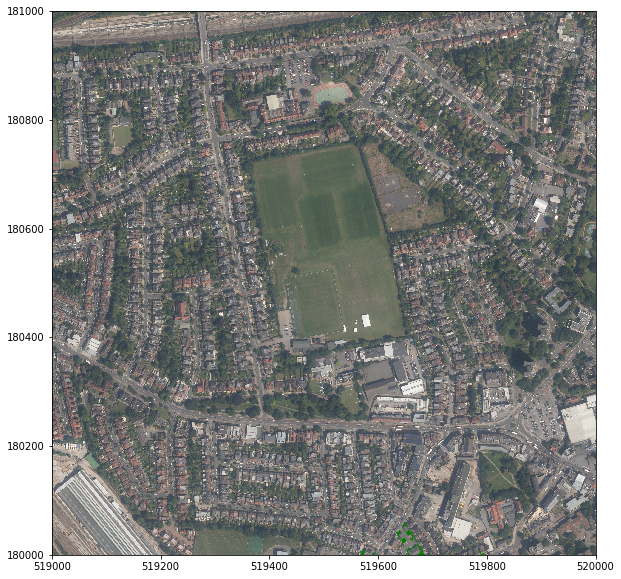

In [259]:
base = g.plot(figsize=(10,10),color = 'green')
plot.show(src, ax = base) #uses rasterio plot module
base.set_xlim = (519600, 519700)
base.set_ylim = (180000, 180100)

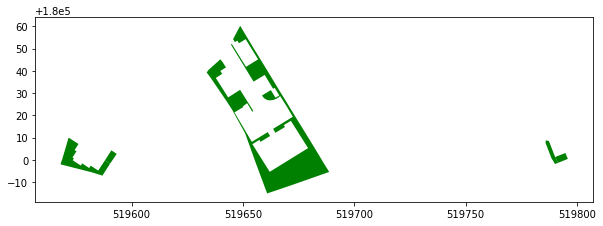

In [260]:
g.plot(figsize=(10,10),color = 'green')

In [242]:
g = gdn.copy(deep=True).iloc[0:1]
g.head()

,id,OBJECTID,TOID,FeatureCode,Version,VersionDate,Theme,ThemeCount,CalculatedAreaValue,ChangeDate,ReasonForChange,ChangeHistoryCount,DescriptiveGroup,DescriptiveGroupCount,DescriptiveTerm,DescriptiveTermCount,Make,PhysicalLevel,PhysicalPresence,broken,SHAPE_Length,SHAPE_Area,geometry
13,643654,643654,1000001778783950,10053,7,2015-01-15T00:00:00,Land,1,696.324061,2015-01-11T00:00:00,Modified,2,General Surface,1,Multi Surface,1.0,Multiple,50,None,false,448.361385,696.324061,"POLYGON ((519657.544 180045.614, 519659.195 18..."


In [246]:
g.TOID.iloc[0] + 'hi'

'1000001778783950hi'

In [237]:
#notes on subsetting gdfs
type(gdn.iloc[0:5]) #returns gdf
type(gdn.iloc[0:1]) #returns gdf

type(gdn.iloc[0]) #returns geoseries !!!! fucking annoying

g = gdn.copy(deep=True).iloc[1:2] #returns gdf

print(type(g)) #returns class = gdf

print(g.type) #returns type of geometry = polygon

<class 'geopandas.geodataframe.GeoDataFrame'>
74    Polygon
dtype: object


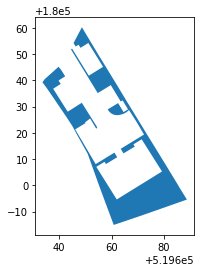

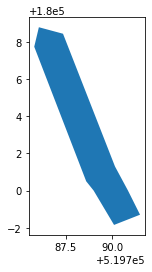

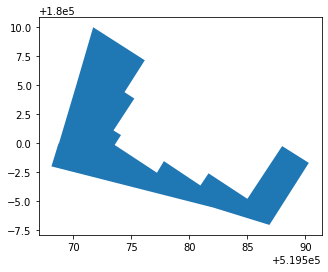

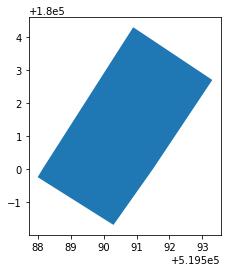

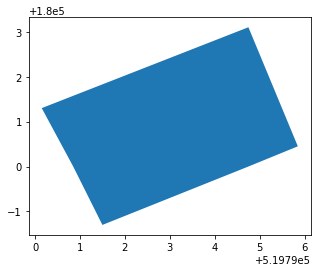

In [232]:
#how to iterate over rows of a gdf by creating single row gdfs to work on.
g = gdn.copy(deep=True).iloc[0:5]
for i in np.arange(g.shape[0]):
    h = g.copy(deep=True).iloc[i:i+1] #specify start and end keeps output as a gdf rather than a geoseries
    h.geometry.plot()

## Crop raster to extent of polygon with earthpy.spatial

Use earthpy.spatial.crop_image(raster, geoms, all_touched=True)

https://earthpy.readthedocs.io/en/latest/api/earthpy.spatial.html

In [55]:
#create gdf of a single garden vector polygon
gdn1 = gdn.query('TOID == "1000001778783950"').drop(['id', 'OBJECTID'], axis=1).drop_duplicates()

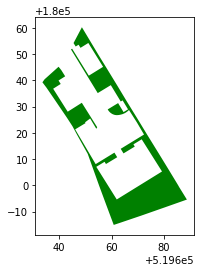

In [58]:
gdn1.plot(color = 'green')

In [79]:
im1, im1meta = es.crop_image(raster = src, geoms = gdn1, all_touched = True)
#this returns an array in im1 and a dictionary of metadata in im1meta
# this only crops to the extent of the shape, so the smallest rectangle it will fit in, in the 
#given orientation
#I want to crop to the precise shape!!!!

In [74]:
im1.shape

(3, 241, 221)

In [70]:
im1meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 221,
 'height': 241,
 'count': 3,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(0.25, 0.0, 519633.5,
        0.0, -0.25, 180060.25)}

# Noooooooooooo!

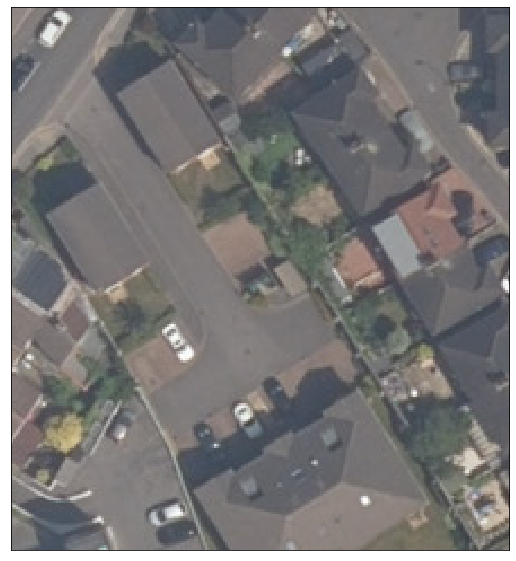

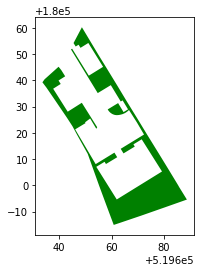

In [83]:
ep.plot_rgb(im1)
gdn1.plot(color = 'green')

## Take one garden shape and overlay

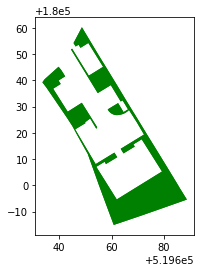

In [40]:
gdn.query('TOID == "1000001778783950"').plot(color = 'green')

### Try with gpd.overlay and sjoin

https://geopandas.org/reference/geopandas.overlay.html
https://geopandas.org/reference/geopandas.sjoin.html

Each of these take a geodataframe, the Aerial photography is not a geodataframe, it is raster data, not vector data... May need to use rasterio methods

https://rasterio.readthedocs.io/en/latest/api/rasterio.merge.html



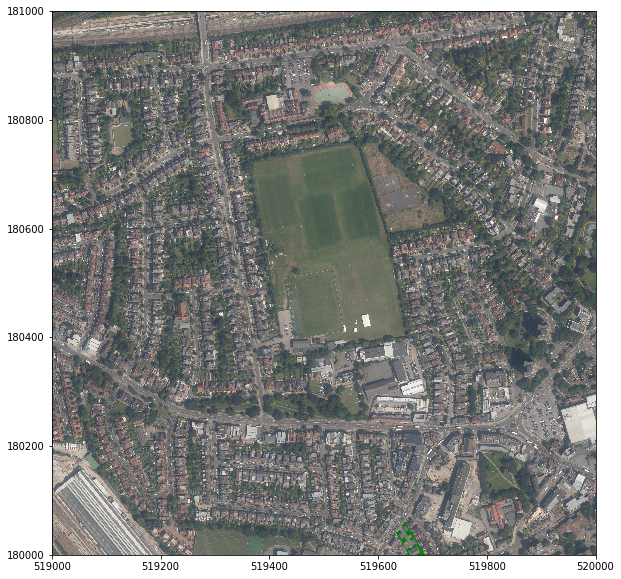

In [41]:
base = gdn.query('TOID == "1000001778783950"').plot(figsize=(10,10),color = 'green')
plot.show(src, ax = base) #uses rasterio plot module

In [ ]:
base = ehl.plot(figsize=(20,20)) #uses gpd plot method
plot.show(src, ax = base) #uses rasterio plot module